# Analysis

In [1]:
%matplotlib inline

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

### Settings

#### Metric Mapping:
- 'fks' = ReadingLevel (document level score, ratio of word & sentence length)
- 'vader' = Sentiment (word count method, applied to each sentence, applied as a difference of sentences)
- 'subj' = Subjectivity (classifier applied to each sentence, score calculated as diffence across sentences)
- 'liwc' = Confidence (word count method)

In [2]:
# Set core metrics
core_metrics = ['fks', 'vader', 'subj', 'liwc']

### Loading 

In [3]:
# Set path to load files from
res_path = '/Users/tom/Documents/GitCode/ConfidenceScanner/scripts/results/'
#res_path = '/Users/wdfox/Documents/GitCode/Confidence_Scanner/scripts/results/'

In [4]:
# Load files
dfs = []
for dat_type in ['Papers', 'PRs']:
    
    d1 = pd.read_csv(os.path.join(res_path, dat_type + '_readability.csv'))
    d2 = pd.read_csv(os.path.join(res_path, dat_type + '_analysis.csv'))
    d3 = pd.read_csv(os.path.join(res_path, dat_type + '_metadata.csv'))
    
    # Merge dataframes - to get all features for particular document type
    dft = pd.merge(d1, d2, on=['id', 'term'])
    df = pd.merge(dft, d3, on=['id', 'term'])
    df['dat_type'] = dat_type
    
    dfs.append(df)

In [5]:
# Combine into one joint df, with all data (papers and press releases)
df = pd.concat(dfs)

In [6]:
## Cleans ups
df.set_index('id', inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)

# Drop old data columns (remove when analysis re-run)
df = df.drop(['fk', 'consen'], axis=1)

In [7]:
# Drop any documents which have zero words
nb = len(df)
df = df[df['n_words'] > 0]
na = len(df)
print(nb - na)

1


In [8]:
# Check out a few rows
df.head()

,term,smog,ar,fkg,fks,lwf,vader,liu,subj,liwc,n_words,n_sentences,has_source_link,has_article_link,has_other_link,region,journal,dat_type
id,,,,,,,,,,,,,,,,,,
29373119,autism,16.6,18.2,15.2,18.86,7.500000,1.0194,-1.0,3.0,6.0,143,9,NaN,NaN,NaN,NaN,Biological psychiatry,Papers
29369294,autism,18.2,22.2,17.7,12.46,7.916667,-2.5924,-2.0,5.0,6.0,189,11,NaN,NaN,NaN,NaN,Acta neurobiologiae experimentalis,Papers
29367178,autism,15.1,14.8,13.1,35.07,7.000000,0.9111,2.0,-2.0,8.0,125,8,NaN,NaN,NaN,NaN,Epilepsy research,Papers
29361396,autism,21.3,23.7,19.8,12.30,18.000000,-0.9329,-3.0,0.0,0.0,116,6,NaN,NaN,NaN,NaN,Neuromuscular disorders : NMD,Papers
29358944,autism,17.3,18.5,16.5,21.02,13.125000,0.0173,1.0,-1.0,6.0,101,7,NaN,NaN,NaN,NaN,Frontiers in genetics,Papers


### Clean Ups

In [9]:
# Remove outliers
n_before = len(df)
for metric in core_metrics:
    std3 = 4 * df[metric].std()
    std_max = df[metric].mean() + std3
    std_min = df[metric].mean() - std3

    df = df[df[metric] > std_min]
    df = df[df[metric] < std_max]
n_after = len(df)

print(n_before - n_after, 'data points dropped.')

156 data points dropped.


### Explore

In [10]:
# Check how many there are of each data type
df['dat_type'].value_counts()

Papers    9899
PRs       5516
Name: dat_type, dtype: int64

In [11]:
# Check how many documents there are for each term
df['term'].value_counts()

diabetes         2528
stroke           1960
perception       1659
vaccines         1407
dementia         1308
cognition        1300
autism           1264
hypertension     1232
epilepsy         1073
consciousness    1026
optogenetics      658
Name: term, dtype: int64

In [12]:
# Check how many of each document there are, split up by document type and term
df.groupby(['dat_type', 'term']).size()

dat_type  term         
PRs       autism            310
          cognition         335
          consciousness      76
          dementia          381
          diabetes         1658
          epilepsy          198
          hypertension      326
          optogenetics       53
          perception        681
          stroke           1051
          vaccines          447
Papers    autism            954
          cognition         965
          consciousness     950
          dementia          927
          diabetes          870
          epilepsy          875
          hypertension      906
          optogenetics      605
          perception        978
          stroke            909
          vaccines          960
dtype: int64

In [13]:
# Descriptive statistics
df.describe()

,smog,ar,fkg,fks,lwf,vader,liu,subj,liwc,n_words,n_sentences,has_source_link,has_article_link,has_other_link
count,15415.000000,15415.000000,15415.000000,15415.000000,15415.000000,15415.000000,15415.000000,15415.000000,15415.000000,15415.000000,15415.000000,5516.000000,5516.000000,5516.000000
mean,15.336263,17.058482,13.945002,33.317143,11.163471,0.630899,-0.455336,-1.917678,3.146805,199.863380,12.336231,0.359137,0.454315,0.034808
std,2.403699,3.240656,2.793793,14.045844,3.828943,2.406481,4.347103,4.561209,5.090251,137.104579,7.924068,0.479791,0.497954,0.183309
min,0.000000,5.000000,3.300000,-23.790000,0.500000,-9.898900,-25.000000,-20.000000,-17.000000,2.000000,1.000000,0.000000,0.000000,0.000000
25%,14.000000,15.000000,12.200000,24.170000,8.200000,-0.654050,-3.000000,-5.000000,0.000000,114.000000,7.000000,0.000000,0.000000,0.000000
50%,15.300000,17.000000,13.900000,34.260000,10.900000,0.541000,0.000000,-2.000000,3.000000,149.000000,10.000000,0.000000,0.000000,0.000000
75%,16.800000,19.000000,15.700000,43.020000,13.250000,1.802600,2.000000,1.000000,6.000000,260.000000,15.000000,1.000000,1.000000,0.000000
max,26.200000,46.500000,30.900000,85.080000,55.500000,11.193500,22.000000,16.000000,24.000000,2310.000000,102.000000,1.000000,1.000000,1.000000


In [14]:
# Check out the descriptive statistics separated out by dat_type
pd.set_option('display.max_columns', 100)
df.groupby(['dat_type']).describe()

ar                                                       fkg  \
           count       mean       std  min   25%   50%   75%   max   count   
dat_type                                                                     
PRs       5516.0  16.861439  2.548445  8.3  15.2  16.7  18.3  46.5  5516.0   
Papers    9899.0  17.168280  3.563988  5.0  14.8  17.2  19.4  37.6  9899.0   

                                                               fks             \
               mean       std  min   25%   50%   75%   max   count       mean   
dat_type                                                                        
PRs       13.674257  2.044548  3.7  12.3  13.6  14.9  23.4  5516.0  39.698599   
Papers    14.095868  3.124469  3.3  12.0  14.2  16.2  30.9  9899.0  29.761217   

                                                       has_article_link  \
                std    min    25%    50%    75%    max            count   
dat_type                                                                  
PRs        9.780422  -7.68  33.44  40.18  46.91  75.88           5516.0   
Papers    14.784840 -23.79  19.89  29.59  39.37  85.08              0.0   

                                                      has_other_link  \
              mean       std  min  25%  50%  75%  max          count   
dat_type                                                               
PRs       0.454315  0.497954  0.0  0.0  0.0  1.0  1.0         5516.0   
Papers         NaN       NaN  NaN  NaN  NaN  NaN  NaN            0.0   

                                                      has_source_link  \
              mean       std  min  25%  50%  75%  max           count   
dat_type                                                                
PRs       0.034808  0.183309  0.0  0.0  0.0  0.0  1.0          5516.0   
Papers         NaN       NaN  NaN  NaN  NaN  NaN  NaN             0.0   

                                                          liu            \
              mean       std  min  25%  50%  75%  max   count      mean   
dat_type                                                                  
PRs       0.359137  0.479791  0.0  0.0  0.0  1.0  1.0  5516.0 -0.418600   
Papers         NaN       NaN  NaN  NaN  NaN  NaN  NaN  9899.0 -0.475806   

           ...    liwc           lwf                                         \
           ...     75%   max   count       mean       std  min    25%   50%   
dat_type   ...                                                                
PRs        ...     9.0  24.0  5516.0  12.621403  4.068186  0.5  10.20  12.5   
Papers     ...     5.0  23.0  9899.0  10.351071  3.430011  1.5   7.75  10.4   

                       n_sentences                                        \
            75%    max       count       mean       std  min   25%   50%   
dat_type                                                                   
PRs       14.75  30.25      5516.0  18.986584  9.355990  1.0  13.0  18.0   
Papers    12.50  55.50      9899.0   8.630468  3.260252  1.0   6.0   8.0   

                      n_words                                             \
           75%    max   count        mean         std  min    25%    50%   
dat_type                                                                   
PRs       24.0  102.0  5516.0  329.911530  149.244842  2.0  239.0  309.0   
Papers    10.0   43.0  9899.0  127.396909   46.750337  3.0   99.0  126.0   

                           smog                                              \
            75%     max   count       mean       std  min   25%   50%   75%   
dat_type                                                                      
PRs       398.0  2310.0  5516.0  15.008176  1.705368  0.0  14.0  14.9  16.0   
Papers    149.0  1095.0  9899.0  15.519083  2.698846  0.0  13.9  15.7  17.3   

                  subj                                                  vader  \
           max   count      mean       std   min  25%  50%  75%   max   count   
dat_type              

## PR specific Stuff

In [15]:
# Check documents by region (PR only)
df['region'].value_counts()

namerica     4154
europe       1086
asia          164
australia      42
africa         34
samerica       15
Name: region, dtype: int64

In [16]:
# Check how many have links
print('Article Link: ', '\t', df['has_article_link'].mean())
print('Source Link: ', '\t', df['has_source_link'].mean())
print('Other Link: ', '\t', df['has_other_link'].mean())

Article Link:  	 0.4543147208121827
Source Link:  	 0.35913705583756345
Other Link:  	 0.03480783176214648


## Analyses

In [17]:
# Check correlation between metrics
corrs = df[core_metrics].corr()
corrs

,fks,vader,subj,liwc
fks,1.000000,0.021627,-0.134175,0.092832
vader,0.021627,1.000000,0.016378,0.109506
subj,-0.134175,0.016378,1.000000,-0.159919
liwc,0.092832,0.109506,-0.159919,1.000000


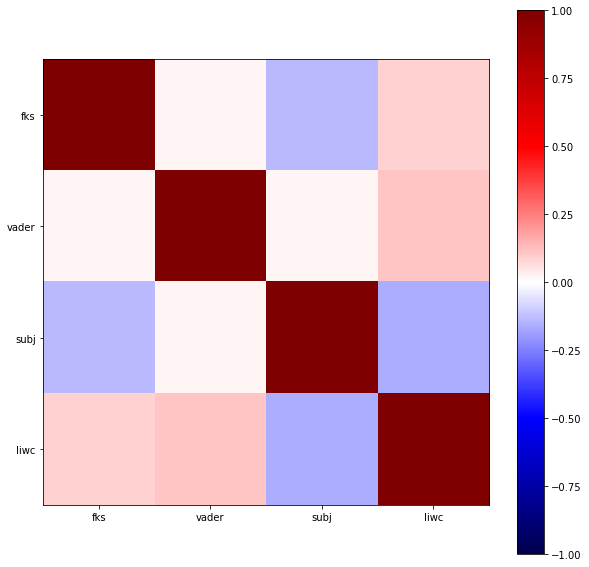

In [18]:
# Plot the correlation matrix
plt.figure(figsize=[10, 10])
plt.imshow(corrs.values, cmap='seismic', vmin=-1, vmax=1);
plt.xticks(range(len(corrs)), list(corrs.columns));
plt.yticks(range(len(corrs)), list(corrs.columns));
plt.colorbar()
#plt.savefig('CorrMat.pdf')

In [19]:
# Check the correlations between all the metrics
for m1 in core_metrics:
    for m2 in core_metrics:
        print(m1, m2, '\t', pearsonr(df[m1], df[m2]))

fks fks 	 (1.0, 0.0)
fks vader 	 (0.021626609899993269, 0.0072487563945894725)
fks subj 	 (-0.13417463139378152, 7.5218570842912107e-63)
fks liwc 	 (0.092832111805519674, 7.4007090401965571e-31)
vader fks 	 (0.021626609899993269, 0.0072487563945894725)
vader vader 	 (1.0, 0.0)
vader subj 	 (0.016377529024157001, 0.04201627313398907)
vader liwc 	 (0.10950596212447393, 2.4505255345049575e-42)
subj fks 	 (-0.13417463139378152, 7.5218570842912107e-63)
subj vader 	 (0.016377529024157001, 0.04201627313398907)
subj subj 	 (1.0, 0.0)
subj liwc 	 (-0.15991863803941925, 7.8748072972432559e-89)
liwc fks 	 (0.092832111805519674, 7.4007090401965571e-31)
liwc vader 	 (0.10950596212447393, 2.4505255345049575e-42)
liwc subj 	 (-0.15991863803941925, 7.8748072972432559e-89)
liwc liwc 	 (1.0, 0.0)


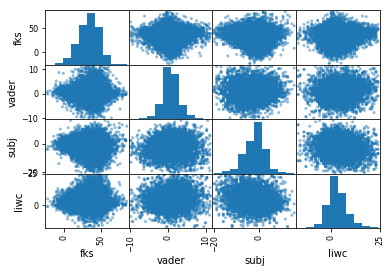

In [20]:
# Plot relations between metrics
pd.plotting.scatter_matrix(df[core_metrics]);

In [21]:
# Check the average scores for each measure across different terms
avgs = df.groupby(['term', 'dat_type'])[core_metrics].mean()
avgs

fks     vader      subj      liwc
term          dat_type                                         
autism        PRs       38.669129  1.611883 -3.267742  5.458065
              Papers    26.790189  0.227726 -0.690776  2.538784
cognition     PRs       39.328955  2.300979 -2.337313  4.519403
              Papers    26.134881  0.509349 -0.420725  2.519171
consciousness PRs       38.986447  0.284682 -2.907895  3.934211
              Papers    29.822600 -0.075455 -0.974737  2.101053
dementia      PRs       38.755669  1.325271 -3.451444  4.469816
              Papers    29.156861  0.436985 -0.778857  2.406688
diabetes      PRs       39.380929  1.143542 -4.117008  4.816647
              Papers    33.662092  0.344294 -1.447126  2.851724
epilepsy      PRs       42.019495  1.201752 -2.883838  4.696970
              Papers    31.787600  0.270679 -1.106286  2.267429
hypertension  PRs       38.273221  0.163219 -3.745399  4.763804
              Papers    33.916115  0.042915 -1.609272  2.747241
optogenetics  PRs       39.246038  2.492258 -3.622642  5.584906
              Papers    17.674777  0.625200 -0.211570  1.897521
perception    PRs       40.098297  1.781945 -2.254038  2.290749
              Papers    29.829468  0.587061 -0.760736  2.483640
stroke        PRs       40.534034  0.486002 -3.556613  4.400571
              Papers    35.876282  0.047822 -1.642464  2.875688
vaccines      PRs       40.284564  1.335344 -4.740492  4.769575
              Papers    29.335667  0.702610 -1.316667  2.076042

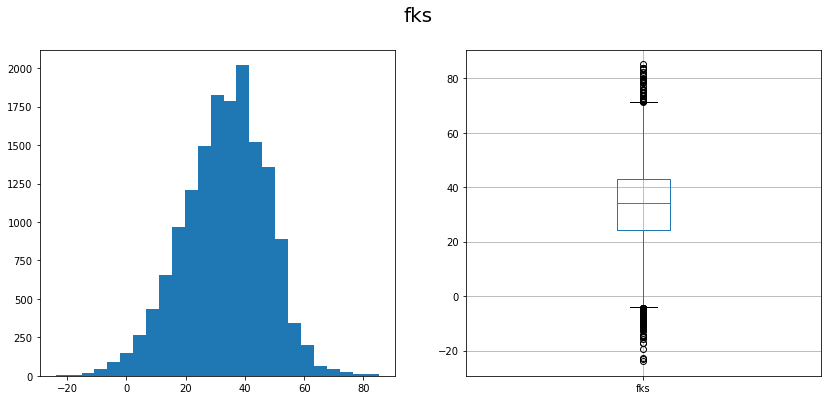

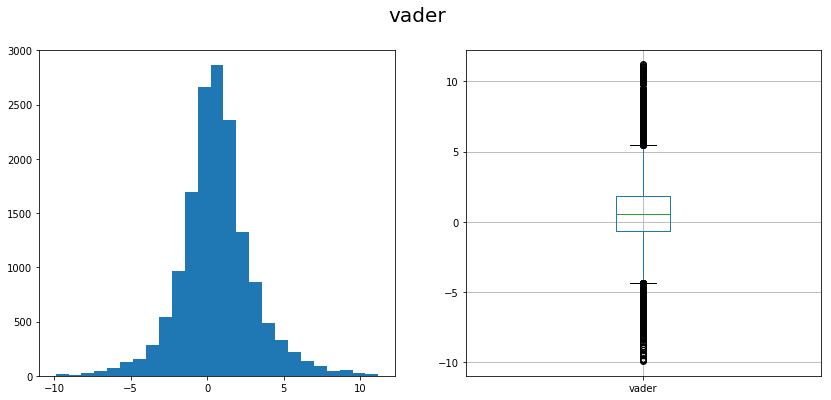

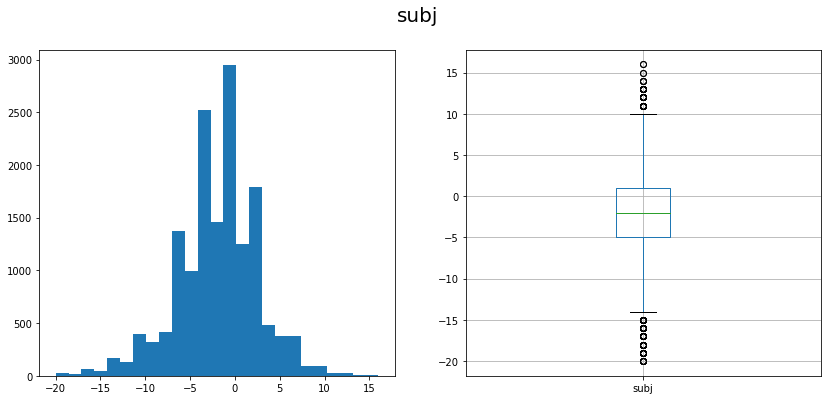

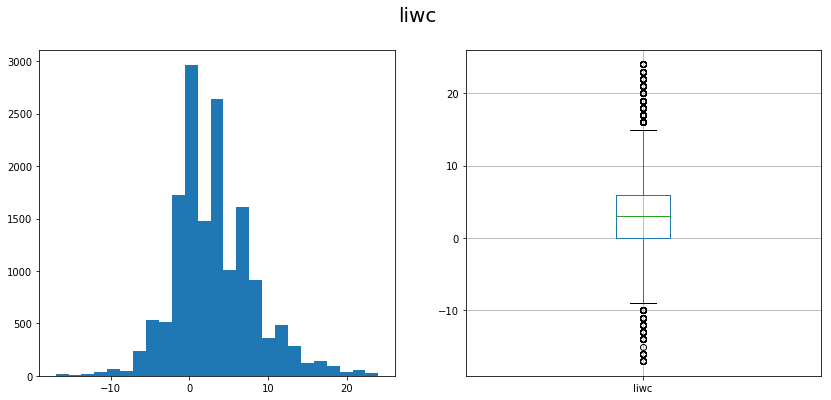

In [22]:
# Plot measures, collapsed across data type
#  Note: these histograms not normalized
for metric in core_metrics:
    fig, ax = plt.subplots(1, 2, figsize=[14, 6])
    ax[0].hist(df[metric], bins=25);
    pd.plotting.boxplot(df, metric, ax=ax[1]);
    plt.suptitle(metric, fontsize=20)

In [23]:
# Check the average differences between data types
df.groupby('dat_type')[core_metrics].mean()

,fks,vader,subj,liwc
dat_type,,,,
PRs,39.698599,1.167061,-3.541334,4.403553
Papers,29.761217,0.332135,-1.012931,2.446510


In [24]:
# Calculate a normalization vector to make histograms sum to one (reflect % of documents)
paper_weights = np.ones_like(df[df.dat_type == 'Papers']['fks'])/float(len(df[df.dat_type == 'Papers']['fks']))
pr_weights = np.ones_like(df[df.dat_type == 'PRs']['fks'])/float(len(df[df.dat_type == 'PRs']['fks']))

# Collect weights together, into a dictionary
weights = {'paper': paper_weights, 'pr': pr_weights}

In [25]:
# Create binning for each measure (so that overlaid histograms share the same binning)
nbins = 25
_, fks_bins = np.histogram(df['fks'], nbins)
_, vader_bins = np.histogram(df['vader'], nbins)
_, subj_bins = np.histogram(df['subj'], nbins)
_, liwc_bins = np.histogram(df['liwc'], nbins)

# Collect bins together into a dictionary
bins = {'fks': fks_bins, 'vader': vader_bins, 'subj': subj_bins, 'liwc': liwc_bins}

In [26]:
# Define helper function for plotting
#  Note: this function presumes some pre-processing (bins & weights as dictionaries)
def plot_comparison(df, measure, title, bins, weights, ax=None):
    
    if not ax:
        fig, ax = plt.subplots()
    
    # Plot settings
    alpha = 0.5
        
    # Make the plot
    ax.hist(df[df.dat_type == 'Papers'][measure], bins=bins[measure], weights=weights['paper'], alpha=alpha, label='Abstracts');
    ax.hist(df[df.dat_type == 'PRs'][measure], bins=bins[measure], weights=weights['pr'], alpha=alpha, label='Press Releases');
    ax.set_title(title, fontsize=15, fontweight='bold')
    ax.legend();
    ax.tick_params(axis='both', which='major', labelsize=12)

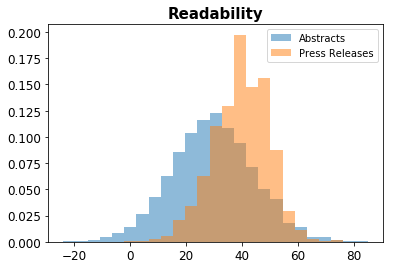

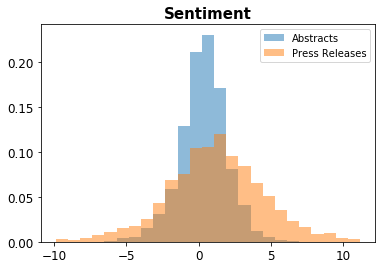

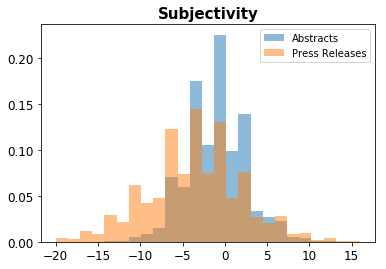

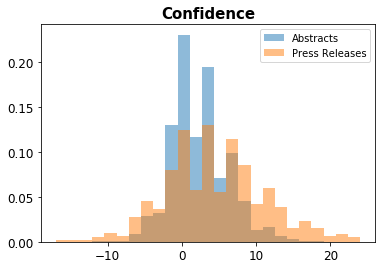

In [27]:
# Plot each figure separately
for meas, title in zip(['fks', 'vader', 'subj', 'liwc'],
                       ['Readability', 'Sentiment', 'Subjectivity', 'Confidence']):
    plot_comparison(df, meas, title, bins, weights)
    plt.savefig(title + '.pdf')

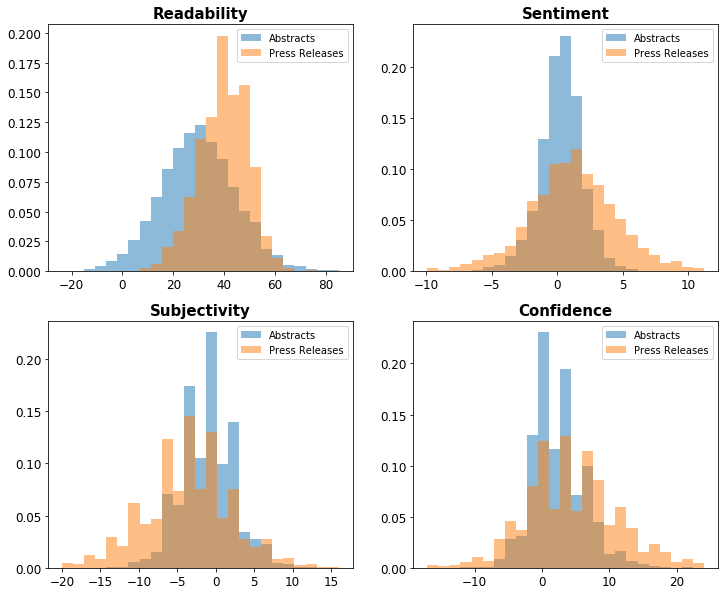

In [28]:
# Plot subplot figure with all measures

fig, ax = plt.subplots(2, 2, figsize=[12, 10])

plot_comparison(df, 'fks', 'Readability', bins, weights, ax=ax[0, 0])
plot_comparison(df, 'vader', 'Sentiment', bins, weights, ax=ax[0, 1])
plot_comparison(df, 'subj', 'Subjectivity', bins, weights, ax=ax[1, 0])
plot_comparison(df, 'liwc', 'Confidence', bins, weights, ax=ax[1, 1])

#plt.savefig('Metrics.pdf', dpi=300, bbox_inches='tight')

In [29]:
# # Plot measures, separated by data type
# for metric in core_metrics:
#     fig, ax = plt.subplots(1, 2, figsize=[14, 6])
    
#     ax[0].hist(df[df.dat_type == 'Papers'][metric], bins=nbins, alpha=alpha, label='Papers');
#     ax[0].hist(df[df.dat_type == 'PRs'][metric], bins=nbins, alpha=alpha, label='PRs');
#     ax[0].legend()
    
#     pd.plotting.boxplot(df, metric, 'dat_type', ax=ax[1])
    
#     plt.suptitle(metric)

### Check correlations of measures with document size

In [30]:
measure = 'liwc'

print('Collapsed')
print('\tWords\t', pearsonr(df[measure], df['n_words']))
print('\tSents\t', pearsonr(df[measure], df['n_sentences']))

print('Separated: N-Words')
print('\tPapers\t', pearsonr(df[df.dat_type == 'Papers'][measure], df[df.dat_type == 'Papers']['n_words']))
print('\tPRs\t', pearsonr(df[df.dat_type == 'PRs'][measure], df[df.dat_type == 'PRs']['n_words']))

print('Separated: N-Sentences')
print('\tPapers\t',pearsonr(df[df.dat_type == 'Papers'][measure], df[df.dat_type == 'Papers']['n_sentences']))
print('\tPRs\t',pearsonr(df[df.dat_type == 'PRs'][measure], df[df.dat_type == 'PRs']['n_sentences']))

Collapsed
	Words	 (0.15739299790174333, 4.5147252207802171e-86)
	Sents	 (0.14389995903602437, 4.1330207244487976e-72)
Separated: N-Words
	Papers	 (0.19988026446869228, 9.5222564923498125e-90)
	PRs	 (-0.011104249751068938, 0.40962786854428279)
Separated: N-Sentences
	Papers	 (0.16593540657376685, 4.765017901536046e-62)
	PRs	 (-0.0075462605881986659, 0.57524750828835247)


# STATISTICS!

In [31]:
from math import sqrt
from statistics import mean, stdev

from scipy.stats import bartlett, ttest_ind

In [32]:
#for metric in ['fkg', 'fks', 'smog', 'ar', 'lwf', 'vader', 'liu', 'subj', 'liwc']:

In [33]:
# Degrees of freedom
degs_free = (df[df.dat_type == 'Papers'].shape[0] + df[df.dat_type == 'Papers'].shape[1] - 2)
print(degs_free)

9915


In [34]:
# Define Cohen's D
def cohens_d(d1, d2):
    return (mean(d1) - mean(d2)) / (sqrt((stdev(d1) ** 2 + stdev(d2) ** 2) / 2))

In [35]:
# Run Bartlett's measure for equal variances across all metrics
for metric in core_metrics:
    print(metric, '\t', bartlett(df[df.dat_type == 'Papers'][metric],
                                  df[df.dat_type == 'PRs'][metric]))

fks 	 BartlettResult(statistic=1094.6410297115715, pvalue=4.8264623414602473e-240)
vader 	 BartlettResult(statistic=3681.6416994794204, pvalue=0.0)
subj 	 BartlettResult(statistic=1450.3579437359986, pvalue=0.0)
liwc 	 BartlettResult(statistic=2383.0342964783922, pvalue=0.0)


In [36]:
# Independent samples t-test (Welch's version - does not assume equal variances)
for metric in core_metrics:
    print(metric, '\t', ttest_ind(df[df.dat_type == 'Papers'][metric],
                                  df[df.dat_type == 'PRs'][metric], equal_var=False))

fks 	 Ttest_indResult(statistic=-50.048656946920055, pvalue=0.0)
vader 	 Ttest_indResult(statistic=-17.5978253578145, pvalue=7.1047822908243471e-68)
subj 	 Ttest_indResult(statistic=30.401781945088548, pvalue=2.3487912467684833e-192)
liwc 	 Ttest_indResult(statistic=-20.111542589749536, pvalue=1.124542577989709e-87)


In [37]:
# Calculate cohens-D effect size between all measures
for metric in core_metrics:
    print(metric, '\t', cohens_d(df[df.dat_type == 'Papers'][metric], df[df.dat_type == 'PRs'][metric]))

fks 	 -0.792776155013
vader 	 -0.320120744415
subj 	 0.540057732743
liwc 	 -0.361628339753


In [38]:
#
df.groupby('dat_type')['liwc'].describe()

,count,mean,std,min,25%,50%,75%,max
dat_type,,,,,,,,
PRs,5516.0,4.403553,6.652053,-17.0,0.0,4.0,9.0,24.0
Papers,9899.0,2.446510,3.784752,-13.0,0.0,2.0,5.0,23.0


In [39]:
# Check direction of effects
df.groupby('dat_type')[core_metrics].describe()

fks                                                           \
           count       mean        std    min    25%    50%    75%    max   
dat_type                                                                    
PRs       5516.0  39.698599   9.780422  -7.68  33.44  40.18  46.91  75.88   
Papers    9899.0  29.761217  14.784840 -23.79  19.89  29.59  39.37  85.08   

           vader                                                        \
           count      mean       std     min     25%     50%       75%   
dat_type                                                                 
PRs       5516.0  1.167061  3.304689 -9.8989 -0.8860  1.2038  3.290575   
Papers    9899.0  0.332135  1.638296 -9.7331 -0.5996  0.3912  1.320100   

                     subj                                                 \
              max   count      mean       std   min  25%  50%  75%   max   
dat_type                                                                   
PRs       11.1935  5516.0 -3.541334  5.567546 -20.0 -7.0 -3.0  0.0  16.0   
Papers     7.9335  9899.0 -1.012931  3.583239 -16.0 -3.0 -1.0  1.0  16.0   

            liwc                                                 
           count      mean       std   min  25%  50%  75%   max  
dat_type                                                         
PRs       5516.0  4.403553  6.652053 -17.0  0.0  4.0  9.0  24.0  
Papers    9899.0  2.446510  3.784752 -13.0  0.0  2.0  5.0  23.0

## EXPLORE: Separating by journal

In [40]:
prs = df[df.dat_type == 'PRs']

prs.journal.value_counts()[prs.journal.value_counts() > 40]

journals = set(prs.journal.value_counts()[prs.journal.value_counts() > 40].index)

In [41]:
# Data: https://www.researchgate.net/publication/321625961_2017_Latest_Impact_Factors_Journal_ListThomson_Reuters_based_on_2016_Journal_Citation_Reports
ifs = {'Cell': 30.410,
       'Cell Reports' : 8.282,
       'JAMA': 44.405,
       'Lancet': 47.831,
       'Nature': 40.137,
       'Nature Communications' : 12.124,
       'Nature Neuroscience' : 17.839,
       'Neurology': 7.592,
       'Neuron': 14.024,
       'New England Journal of Medicine' : 72.406,
       'PLOS ONE': 2.806,
       'Proceedings of the National Academy of Sciences': 9.661,
       'Science': 37.205,
       'Science Translational Medicine': 16.796,
       'Scientific Reports': 4.259,
       'eLife': 7.725,
       "Journal of Alzheimer's Disease" : 3.731,
       'Psychological Science' : 5.667,
       'Current Biology' : 8.851,
       'Journal of the American College of Cardiology' : 19.896,
       'JAMA Neurology' : 10.029}

(0.108164212345009, 0.64071986712262596)


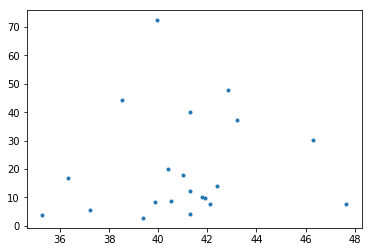

In [42]:
d1 = []
d2 = []
for ke, va in ifs.items():
    d1.append(np.median(prs[prs.journal == ke].fks))
    d2.append(va)
    
print(pearsonr(d1, d2))
plt.plot(d1, d2, '.')

## EXPLORE: ANOVA (?)

Maybe something to do. MESSY EXPLORATIONS.

In [43]:
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

/Users/tom/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [44]:
df.columns

Index(['term', 'smog', 'ar', 'fkg', 'fks', 'lwf', 'vader', 'liu', 'subj',
       'liwc', 'n_words', 'n_sentences', 'has_source_link', 'has_article_link',
       'has_other_link', 'region', 'journal', 'dat_type'],
      dtype='object')

In [45]:
#lm = ols('liwc ~ dat_type + n_words', data=df).fit()
lm = ols('liwc ~ subj + vader + fks + n_words + dat_type', data=df).fit()
table = sm.stats.anova_lm(lm, typ=2)

In [46]:
table

,sum_sq,df,F,PR(>F)
dat_type,1476.692842,1.0,60.420001,8.145162e-15
subj,5645.326092,1.0,230.982774,8.638903e-52
vader,3116.964273,1.0,127.532944,1.854037e-29
fks,306.281064,1.0,12.531721,4.012805e-04
n_words,519.004893,1.0,21.235477,4.094333e-06
Residual,376603.103632,15409.0,NaN,NaN


In [47]:
lm = ols('liwc ~ dat_type', data=df).fit()
table = sm.stats.anova_lm(lm, typ=2)

In [48]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                   liwc   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     542.0
Date:                Tue, 17 Jul 2018   Prob (F-statistic):          7.52e-118
Time:                        21:52:57   Log-Likelihood:                -46691.
No. Observations:               15415   AIC:                         9.339e+04
Df Residuals:                   15413   BIC:                         9.340e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.4036      0

In [49]:
table

,sum_sq,df,F,PR(>F)
dat_type,13566.662882,1.0,541.970119,7.519791e-118
Residual,385820.117267,15413.0,NaN,NaN


In [50]:
# compute one-way ANOVA P value   
from scipy import stats  
      
f_val, p_val = stats.f_oneway(df[df.dat_type == 'Papers']['liwc'].values,
                              df[df.dat_type == 'PRs']['liwc'].values)
